In [2]:
import obspy
import obsplus
import pandas as pd
from obspy.clients.fdsn import Client
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import numpy as np
import logging
import requests
import seisbench
import seisbench.models as sbm
import dask
import json
import alaska_utils

# Progress bar for dask operations:
from dask.diagnostics import ProgressBar
pbar = dask.diagnostics.ProgressBar()
pbar.register()

#### Download waveforms

In [3]:
# Load master station list
dfS = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_stations.parquet')

# Convert to pandas datetime
dfS['start_date']=pd.to_datetime(dfS['start_date'],infer_datetime_format=True,errors='coerce')
dfS['end_date']=pd.to_datetime(dfS['end_date'],infer_datetime_format=True,errors='coerce')

In [4]:
# Download waveforms

step = 60
t1 = datetime.datetime(2018,5,25,12,35)
t1 = datetime.datetime(2019,5,27,9,52,30)
t2 = t1 + pd.Timedelta(3,'minutes')
time_bins = pd.to_datetime(np.arange(t1,t2,pd.Timedelta(step,'seconds')))

@dask.delayed
def loop_times(dfS,t1,step):
    return alaska_utils.retrieve_waveforms(dfS,t1,t1+pd.Timedelta(step,'seconds'))

lazy_results = [loop_times(dfS,time,step) for time in time_bins]

In [5]:
results = dask.compute(lazy_results)

[########################################] | 100% Completed | 49.5s
[########################################] | 100% Completed | 49.6s


In [ ]:
# Optional- save to miniseed:
stream = obspy.core.stream.Stream()
for st in results[0]:
    stream.extend(st)
stream.write("alaska_1hour.mseed", format="MSEED") 

stream = obspy.core.stream.read('alaska_1hour.mseed')

#### Denoise

In [6]:
%%time
model = sbm.DeepDenoiser.from_pretrained("original")

CPU times: user 33.4 ms, sys: 2.17 ms, total: 35.6 ms
Wall time: 32.7 ms


In [7]:
%%time
denoise = []
for st in results[0]:
    den = model.annotate(st)
    denoise.append(den)

CPU times: user 28.1 s, sys: 904 ms, total: 29 s
Wall time: 13.7 s


#### Phase pick

In [8]:
model = sbm.EQTransformer.from_pretrained("original")

In [9]:
%%time
annotation = []
pick = []
detection = []
for st in denoise:
    at = model.annotate(st)
    pks, dets = model.classify(st)
    annotation.append(at); pick.append(pks); detection.append(dets);

2022-02-03 00:41:13,199 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-02-03 00:41:14,513 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-02-03 00:41:15,859 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-02-03 00:41:17,214 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.


CPU times: user 20.5 s, sys: 911 ms, total: 21.4 s
Wall time: 8.49 s


In [10]:
stream = obspy.core.stream.Stream()
for st in results[0]:
    stream.extend(st)
denoised = obspy.core.stream.Stream()
for st in denoise:
    denoised.extend(st)
annotations = obspy.core.stream.Stream()
for st in annotation:
    annotations.extend(st)

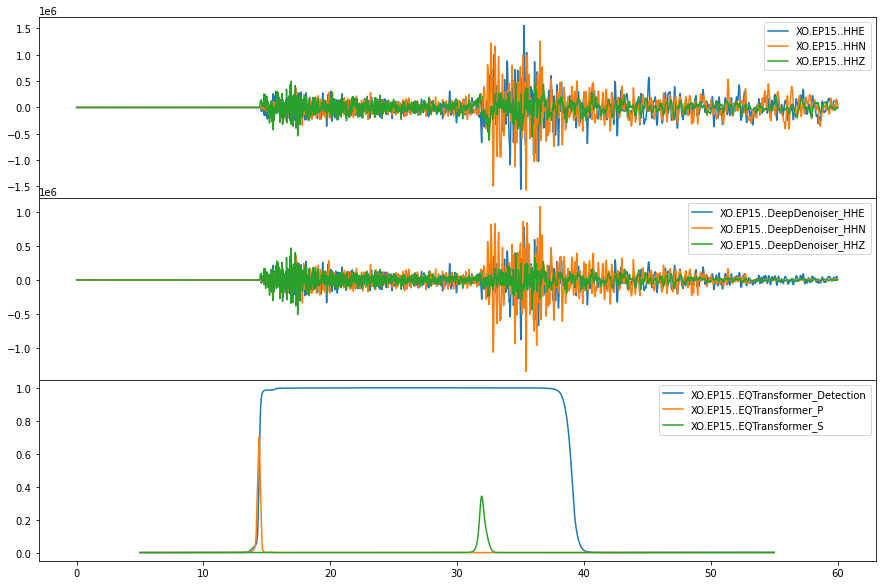

In [21]:
# GUT CHECK

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - denoised[0].stats.starttime
for i in [12,13,14]: #LT03
    axs[0].plot(stream[i+2].times(), stream[i+2].data, label=stream[i+2].id) #NOTICE: indices are off
    axs[1].plot(denoised[i].times(), denoised[i].data, label=denoised[i].id)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[2].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].id)

axs[0].legend()
axs[1].legend()
axs[2].legend()

In [23]:
# Which one didn't quakeflow like?

og_ids = [p.id[0:7] for p in stream]
new_ids = [p.id[0:7] for p in annotations]
set(og_ids) ^ set(new_ids)

set()

#### Convert picks to be GAMMA-compatible

In [113]:
gamma_picks = []
for pick in picks:
    pdict = {'id':pick.trace_id,'timestamp':pick.peak_time,'prob':pick.peak_value,'type':pick.phase}
    gamma_picks.append(pdict)

In [115]:
gamma_picks[0]

{'id': 'XO.EP15.',
 'timestamp': 2019-05-27T09:53:01.930001Z,
 'prob': 0.34268081,
 'type': 'S'}